In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

#import graphviz
#import tensorflow as tf



from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
DIR = Path('./preprocessed/')

train = pd.read_csv(DIR / 'train_preprocessed.csv')
validation = pd.read_csv(DIR / 'validation_preprocessed.csv')

train["date"] = pd.to_datetime(train.date)
validation["date"] = pd.to_datetime(validation.date)

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")

validation.onpromotion = validation.onpromotion.astype("float16")
validation.sales = validation.sales.astype("float32")

In [4]:
train = train.drop(['onpromotion'], axis=1)
validation = validation.drop(['onpromotion'], axis=1)

In [5]:
validation.set_index('date', inplace=True)
train.set_index('date', inplace=True)

In [7]:
validation.head()

,sales
date,
2017-07-31,885856.8125
2017-08-01,988527.7500
2017-08-02,964712.0000
2017-08-03,728068.5000
2017-08-04,827775.6875


## EDA

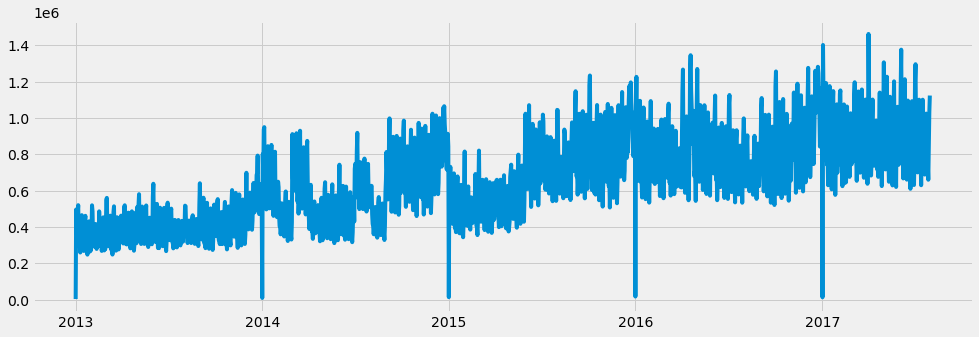

In [8]:
plt.figure(figsize=(15,5))
plt.plot(train.sales)

In [50]:
# what are possible candidates for further time-series plots?


## Split Data

## Feature Engineering

In [39]:
# Feature Engineering
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['y_difference'] = df.sales.diff()
    df['x_difference'] = df.y_difference.shift(1)
    df['y_sales'] = df.sales
    df['x_sales'] = df.sales.shift(1)

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'x_difference']]
    y = df[['y_sales', 'y_difference', 'x_sales']]
    return X, y

In [40]:
X_train, y_train = create_features(train, label='sales')
X_test, y_test = create_features(validation, label='sales')

/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_66415/3154713137.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_66415/3154713137.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [41]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x_difference
date,,,,,,,,,
2013-01-01,0,1,1,1,2013,1,1,1,NaN
2013-01-02,0,2,1,1,2013,2,2,1,NaN
2013-01-03,0,3,1,1,2013,3,3,1,493580.78125
2013-01-04,0,4,1,1,2013,4,4,1,-134631.18750
2013-01-05,0,5,1,1,2013,5,5,1,-7001.53125
...,...,...,...,...,...,...,...,...,...
2017-07-26,0,2,3,7,2017,207,26,30,-102982.68750
2017-07-27,0,3,3,7,2017,208,27,30,27071.43750
2017-07-28,0,4,3,7,2017,209,28,30,-80803.25000


In [42]:
y_train

,y_sales,y_difference,x_sales
date,,,
2013-01-01,2.511619e+03,NaN,NaN
2013-01-02,4.960924e+05,493580.78125,2.511619e+03
2013-01-03,3.614612e+05,-134631.18750,4.960924e+05
2013-01-04,3.544597e+05,-7001.53125,3.614612e+05
2013-01-05,4.773501e+05,122890.43750,3.544597e+05
...,...,...,...
2017-07-26,7.406531e+05,27071.43750,7.135816e+05
2017-07-27,6.598498e+05,-80803.25000,7.406531e+05
2017-07-28,8.350997e+05,175249.87500,6.598498e+05


## Train Model

In [50]:
# in x_train and y_train remove Nans and replace with 0
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
X_test = X_test.fillna(0)

In [56]:
reg = DecisionTreeRegressor(max_depth = 20)
reg.fit(X_train, y_train['y_difference'])



DecisionTreeRegressor(max_depth=20)

In [81]:
# plt.figure(figsize=(10,8), dpi=150)

# plot_tree(reg, feature_names=X_train.columns, filled=True, rounded=True) 
# plt.show()



## Predict

In [57]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

In [58]:
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x_difference
date,,,,,,,,,
2017-07-31,0,0,3,7,2017,212,31,31,0.0000
2017-08-01,0,1,3,8,2017,213,1,31,0.0000
2017-08-02,0,2,3,8,2017,214,2,31,102670.9375
2017-08-03,0,3,3,8,2017,215,3,31,-23815.7500
2017-08-04,0,4,3,8,2017,216,4,31,-236643.5000
2017-08-05,0,5,3,8,2017,217,5,31,99707.1875
2017-08-06,0,6,3,8,2017,218,6,31,137917.9375
2017-08-07,0,0,3,8,2017,219,7,32,83865.5000
2017-08-08,0,1,3,8,2017,220,8,32,-252094.1875


In [65]:
validation['prediction_difference'] = reg.predict(X_test)
validation['prediction_sales'] =validation['prediction_difference'] + validation['x_sales']
data_all = pd.concat([train, validation], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,difference,y_difference,x_difference,y_sales,x_sales,sales_Prediction,prediction_difference,prediction_sales
date,,,,,,,,,,,,,,,,,,
2013-01-01,2511.618896,2013-01-01,0,1,1,1,2013,1,1,1,NaN,NaN,NaN,2511.618896,NaN,NaN,NaN,NaN
2013-01-02,496092.406250,2013-01-02,0,2,1,1,2013,2,2,1,493580.78125,493580.78125,NaN,496092.406250,2511.618896,NaN,NaN,NaN
2013-01-03,361461.218750,2013-01-03,0,3,1,1,2013,3,3,1,-134631.18750,-134631.18750,493580.78125,361461.218750,496092.406250,NaN,NaN,NaN
2013-01-04,354459.687500,2013-01-04,0,4,1,1,2013,4,4,1,-7001.53125,-7001.53125,-134631.18750,354459.687500,361461.218750,NaN,NaN,NaN
2013-01-05,477350.125000,2013-01-05,0,5,1,1,2013,5,5,1,122890.43750,122890.43750,-7001.53125,477350.125000,354459.687500,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.750000,2017-08-11,0,4,3,8,2017,223,11,32,174986.81250,174986.81250,-82752.75000,826373.750000,651386.937500,7.488000e+05,94130.25000,745517.18750
2017-08-12,792630.562500,2017-08-12,0,5,3,8,2017,224,12,32,-33743.18750,-33743.18750,174986.81250,792630.562500,826373.750000,1.100833e+06,150483.75000,976857.50000
2017-08-13,865639.687500,2017-08-13,0,6,3,8,2017,225,13,32,73009.12500,73009.12500,-33743.18750,865639.687500,792630.562500,9.329021e+05,46920.18750,839550.75000


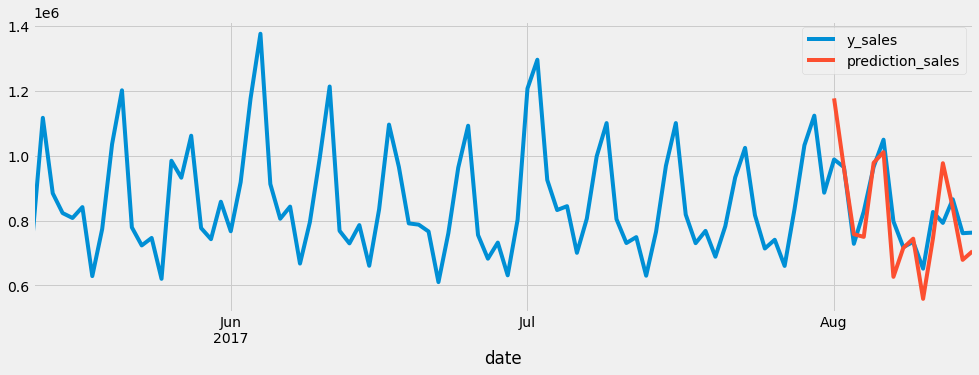

In [66]:
_ = data_all[['y_sales','prediction_sales']].tail(16*6).plot(figsize=(15, 5))


In [63]:
data_all.tail(10)

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,difference,y_difference,x_difference,y_sales,x_sales,sales_Prediction,prediction_difference,prediction_sales
date,,,,,,,,,,,,,,,,,,
2017-07-21,7.824183e+05,2017-07-21,0,4,3,7,2017,202,21,29,94130.2500,94130.2500,-79690.6875,7.824183e+05,6.882881e+05,NaN,NaN,NaN
2017-07-22,9.329021e+05,2017-07-22,0,5,3,7,2017,203,22,29,150483.7500,150483.7500,94130.2500,9.329021e+05,7.824183e+05,NaN,NaN,NaN
2017-07-23,1.024289e+06,2017-07-23,0,6,3,7,2017,204,23,29,91386.6875,91386.6875,150483.7500,1.024289e+06,9.329021e+05,NaN,NaN,NaN
2017-07-24,8.165643e+05,2017-07-24,0,0,3,7,2017,205,24,30,-207724.4375,-207724.4375,91386.6875,8.165643e+05,1.024289e+06,NaN,NaN,NaN
2017-07-25,7.135816e+05,2017-07-25,0,1,3,7,2017,206,25,30,-102982.6875,-102982.6875,-207724.4375,7.135816e+05,8.165643e+05,NaN,NaN,NaN
2017-07-26,7.406531e+05,2017-07-26,0,2,3,7,2017,207,26,30,27071.4375,27071.4375,-102982.6875,7.406531e+05,7.135816e+05,NaN,NaN,NaN
2017-07-27,6.598498e+05,2017-07-27,0,3,3,7,2017,208,27,30,-80803.2500,-80803.2500,27071.4375,6.598498e+05,7.406531e+05,NaN,NaN,NaN
2017-07-28,8.350997e+05,2017-07-28,0,4,3,7,2017,209,28,30,175249.8750,175249.8750,-80803.2500,8.350997e+05,6.598498e+05,NaN,NaN,NaN
2017-07-29,1.032311e+06,2017-07-29,0,5,3,7,2017,210,29,30,197211.1875,197211.1875,175249.8750,1.032311e+06,8.350997e+05,NaN,NaN,NaN


In [17]:
# Task: compare the result for decision trees, that differ in their complexity i.e. depth of the tree

## Prediction Error Analysis

In [86]:
validate_['error'] = validate_['sales'] - validate_['sales_Prediction']
validate_['abs_error'] = validate_['error'].apply(np.abs)
error_by_day = validate_.groupby(['year','month','dayofmonth']) \
    .mean()[['sales','sales_Prediction','error','abs_error']]



In [87]:
error_by_day.sort_values('error', ascending=True).head(10)

# 2015-12-25 (Christmas) and 2017-05-29 (memorial day holiday) are holidays in America -> maybe add holiday feature

sales  sales_Prediction          error  \
year month dayofmonth                                                   
2017 1     1            12082.500997     742732.830236 -730650.329239   
2015 3     5           428599.809059     741756.416525 -313156.607466   
     1     3           648880.686926     936628.886604 -287748.199678   
     3     15          662700.871933     929808.492772 -267107.620839   
           4           483330.548167     748930.902096 -265600.353929   
           3           492365.240830     748930.902096 -256565.661266   
           29          641213.770163     873958.839642 -232745.069479   
           28          589854.704057     822333.142686 -232478.438628   
     1     4           730923.776022     949618.788940 -218695.012918   
           8           417482.689131     636176.853478 -218694.164347   

                           abs_error  
year month dayofmonth                 
2017 1     1           730650.329239  
2015 3     5           313156.607466  
     1     3           287748.199678  
     3     15          267107.620839  
           4           265600.353929  
           3           256565.661266  
           29          232745.069479  
           28          232478.438628  
     1     4           218695.012918  
           8           218694.164347

## Random Forest

In [88]:
rf = RandomForestRegressor()

In [89]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [90]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [91]:
validate_['sales'] = rf.predict(X_test)

data_all = pd.concat([validate_, train_], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction,error,abs_error
date,,,,,,,,,,,,,
2015-01-02,475568.700295,2015-01-02,0,4,1,1,2015,2,2,1,801011.226041,-143247.834060,143247.834060
2015-01-03,907805.252584,2015-01-03,0,5,1,1,2015,3,3,1,936628.886604,-287748.199678,287748.199678
2015-01-04,914483.569720,2015-01-04,0,6,1,1,2015,4,4,1,949618.788940,-218695.012918,218695.012918
2015-01-05,537985.143071,2015-01-05,0,0,1,1,2015,5,5,2,602268.564009,-33001.266049,33001.266049
2015-01-06,528100.304906,2015-01-06,0,1,1,1,2015,6,6,2,602268.564009,-124381.822956,124381.822956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN,NaN,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN,NaN,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN,NaN,NaN


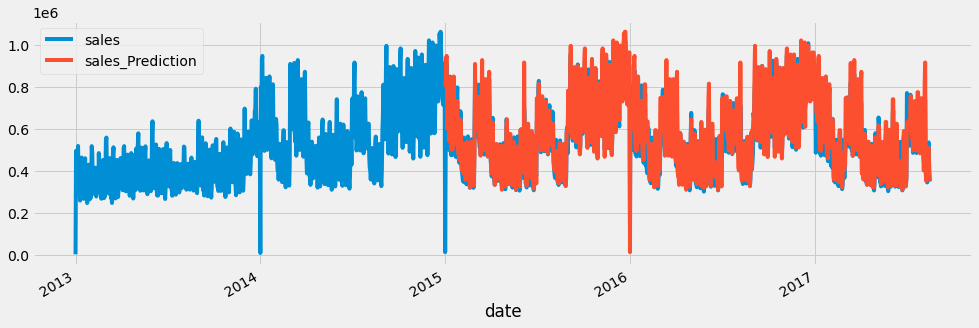

In [92]:
_ = data_all[['sales','sales_Prediction']].plot(figsize=(15, 5))


In [25]:
## Perform Hyeroarameter Tuning for the Random Forest. Use different approaches 
#(random search, grid search, Sequantial Model Based Optimization and a Genetic Algorithm)

In [ ]:
# Random Search


In [93]:
# Perform a grid search for the best parameters for the random forest
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
                            
grid_search.fit(X_train, y_train)

grid_search.best_params_

# Use this grid_search.best_params_ to create a new random forest with the best parameters
rf = RandomForestRegressor(bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)



Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] E

In [95]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=1000)

In [96]:
# Define mean_squared_log_error
from sklearn.metrics import mean_squared_log_error

# Get the Root Mean Squared Logarithmic Error (RMSLE) for the random forest
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Get the RMSLE for the random forest on the test data
rmsle(y_test, rf.predict(X_test))

# Get the RMSLE for the random forest on the train data
rmsle(y_train, rf.predict(X_train))



0.27416784190891913

In [97]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [98]:
validate_['sales'] = rf.predict(X_test)

data_all = pd.concat([validate_, train_], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction,error,abs_error
date,,,,,,,,,,,,,
2015-01-02,470732.664871,2015-01-02,0,4,1,1,2015,2,2,1,801011.226041,-143247.834060,143247.834060
2015-01-03,720188.603438,2015-01-03,0,5,1,1,2015,3,3,1,936628.886604,-287748.199678,287748.199678
2015-01-04,739512.703215,2015-01-04,0,6,1,1,2015,4,4,1,949618.788940,-218695.012918,218695.012918
2015-01-05,539816.704456,2015-01-05,0,0,1,1,2015,5,5,2,602268.564009,-33001.266049,33001.266049
2015-01-06,536219.241476,2015-01-06,0,1,1,1,2015,6,6,2,602268.564009,-124381.822956,124381.822956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN,NaN,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN,NaN,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN,NaN,NaN


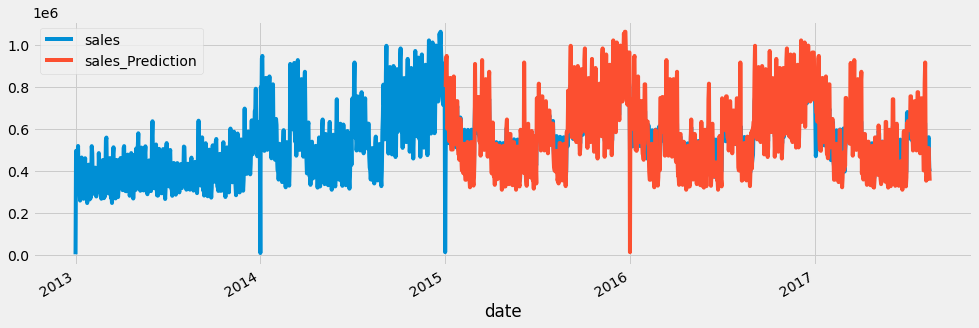

In [99]:
_ = data_all[['sales','sales_Prediction']].plot(figsize=(15, 5))
